In [1]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2, skbio, hdmedians as hd
from biom import load_table, Table
from biom.util import biom_open
from emperor import Emperor, nbinstall; nbinstall()

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [2]:
mf = load_mf('data/new-categories.1.tsv', 'sample_name')
# remove blanks
mf = mf.query('empo_1 == "Host-associated"').copy()

In [7]:
table = q2.Artifact.import_data('FeatureTable[Frequency]', 'data/boland_biom_original.biom')
table.save('data/feature-table.qza')

!qiime feature-table filter-samples \
--i-table data/feature-table.qza \
--m-metadata-file data/11546_20190819-143944.txt \
--p-where "empo_1 == 'Host-associated'" \
--p-min-frequency 40000 \
--o-filtered-table data/feature-table.noblanks.40k.qza 

!qiime feature-table rarefy \
--i-table data/feature-table.noblanks.40k.qza \
--p-sampling-depth 40000 \
--p-with-replacement \
--o-rarefied-table data/feature-table.noblanks.even40k.qza

!qiime diversity beta --p-metric braycurtis \
--o-distance-matrix braycurtis.qza \
--i-table data/feature-table.noblanks.even40k.qza

Saved FeatureTable[Frequency] to: data/feature-table.noblanks.40k.qza
Saved FeatureTable[Frequency] to: data/feature-table.noblanks.even40k.qza
Saved DistanceMatrix to: braycurtis.qza


In [3]:
# the shannon.qza file is created based on a 40K rarefaction depth
mf['shannon'] = q2.Artifact.load('shannon.qza').view(pd.Series)

It's important to load a non-rarefied table for ANCOM.

In [4]:
table = q2.Artifact.load('data/feature-table.noblanks.40k.qza').view(pd.DataFrame)
dm = q2.Artifact.load('braycurtis.qza').view(skbio.DistanceMatrix)
feature_metadata = load_table('data/boland_biom_original.biom').metadata_to_dataframe('observation')

In [5]:
annotations = pd.read_csv('data/Biobank_Bile_Acids - Sheet1.tsv', sep='\t')

We need to combine the mass over charge and the retention times, and additionally truncate any trailing zeroes to make them match the feature table.

In [6]:
def combine(row):
    a = '%.4f' % float(row['row m/z'])
    b = '%.4f' % float(row['row retention time'])
    
    if a.endswith('0'):
        a = a[:-1]
    if b.endswith('0'):
        b = b[:-1]
    return '%s;%s' % (a, b)
    
annotations['id'] = annotations.apply(combine, axis=1)

annotations.set_index('id', inplace=True)

In [7]:
def renamer(row):
    if row['Compound_Name'] == '':
        return 'Unidentified %s bile acid' % row['Type of Bile Acid'].lower()
    else:
        return row['Compound_Name']
annotations['Compound_Name'] = annotations.apply(renamer, axis=1)

In [8]:
lookup = {
    'Cholic acid': 'Cholic acid',
    'Spectral Match to Cholic acid from NIST14': 'Cholic acid',
    '.beta.-Hyodeoxycholic acid': '',
    'glycochenodeoxycholic acid' : 'Glycochenodeoxycholic acid',
    'Spectral Match to Deoxycholic acid from NIST14': 'Deoxycholic acid',
    'Spectral Match to Taurocholic acid from NIST14': 'Taurocholic acid',
    'chenodeoxycholic acid': 'Chenodeoxycholic acid',
    'Phenylalanocholic acid': 'Phenylalanocholic acid',
    'Glycodeoxycholic acid': 'Glycodeoxycholic acid',
    'Spectral Match to Glycocholic acid from NIST14': 'Glycocholic acid',
    'Spectral Match to Ursodeoxycholic acid from NIST14': 'Ursodeoxycholic acid'}

annotations.Compound_Name.replace(lookup, inplace=True)

We need to remove any conjugated types of bile acids because they are not very prevalent.

In [9]:
annotations = annotations[annotations['Type of Bile Acid'].str.find('Conjugated') == -1]

Combine the feature table and the annotations to convert them into a long table.

In [10]:
annotations.head()

,#Scan#,Compound_Name,LibMZ,Type of Bile Acid,Unnamed: 4,row ID,row m/z,row retention time
id,,,,,,,,
373.2737;5.198,7,Cholic acid,373.274,Primary,NaN,7,373.273671,5.198008
355.2636;4.5634,16,Cholic acid,355.263,Primary,NaN,16,355.263633,4.563430
375.289;5.9381,30,Chenodeoxycholic acid,375.290,Primary,NaN,30,375.288992,5.938127
355.2633;5.1946,80,Cholic acid,355.263,Primary,NaN,80,355.263274,5.194641
431.2768;5.1948,100,Cholic acid,431.277,Primary,NaN,100,431.276844,5.194850


In [11]:
features = table.T.copy()
features['name'] = annotations['Type of Bile Acid']

In [12]:
features = features.dropna(axis=0, subset=['name'], how='any')

In [13]:
features = features.groupby('name').agg('sum').T

In [20]:
mf['category_2'].value_counts()

Control                   241
Ileocolonic resection      59
Colectomy with pouch       32
End ileostomy              11
Ileorectal anastomosis      9
Name: category_2, dtype: int64

In [39]:
features['category_1'] = mf['category_1']
features['category_2'] = mf['category_2']
features['category_3'] = mf['category_3']
features['has_surgery'] = (mf['category_2'] != 'Control').astype(str)
features['endoscopic_activity'] = mf['endoscopic_activity']

In [40]:
features.dtypes

name
Primary                float64
Secondary              float64
category_1              object
category_2              object
category_3              object
endoscopic_activity     object
has_surgery             object
dtype: object

In [41]:
features.columns

Index(['Primary', 'Secondary', 'category_1', 'category_2', 'category_3',
       'endoscopic_activity', 'has_surgery'],
      dtype='object', name='name')

In [42]:
alt = ['.alpha.-Hyodeoxycholic acid methyl ester', 'Chenodeoxycholic acid',
       'Cholic acid', 'Deoxycholic acid', 'Lithocholic acid',
       'Unidentified secondary bile acid', 'Ursodeoxycholic acid']
long_features = features.melt(value_name='intensity',
                value_vars=['Primary', 'Secondary'],
                id_vars=['category_1', 'category_2', 'category_3', 'has_surgery', 'endoscopic_activity']
               ).copy()

In [26]:
long_features.head()

,category_1,category_2,category_3,has_surgery,endoscopic_activity,name,intensity
0,cd,Control,Control,False,active,Primary,8.600483e+05
1,uc,Control,Control,False,inactive,Primary,8.611506e+05
2,cd,Ileocolonic resection,Ileocolonic resection,True,active,Primary,7.258683e+06
3,uc,Control,Control,False,inactive,Primary,8.489328e+05
4,uc,Control,Control,False,not collected,Primary,6.370008e+05


In [27]:
long_features.head()

,category_1,category_2,category_3,has_surgery,endoscopic_activity,name,intensity
0,cd,Control,Control,False,active,Primary,8.600483e+05
1,uc,Control,Control,False,inactive,Primary,8.611506e+05
2,cd,Ileocolonic resection,Ileocolonic resection,True,active,Primary,7.258683e+06
3,uc,Control,Control,False,inactive,Primary,8.489328e+05
4,uc,Control,Control,False,not collected,Primary,6.370008e+05


In [18]:
mf.endoscopic_activity.value_counts()

active           136
not collected    135
inactive          81
Name: endoscopic_activity, dtype: int64

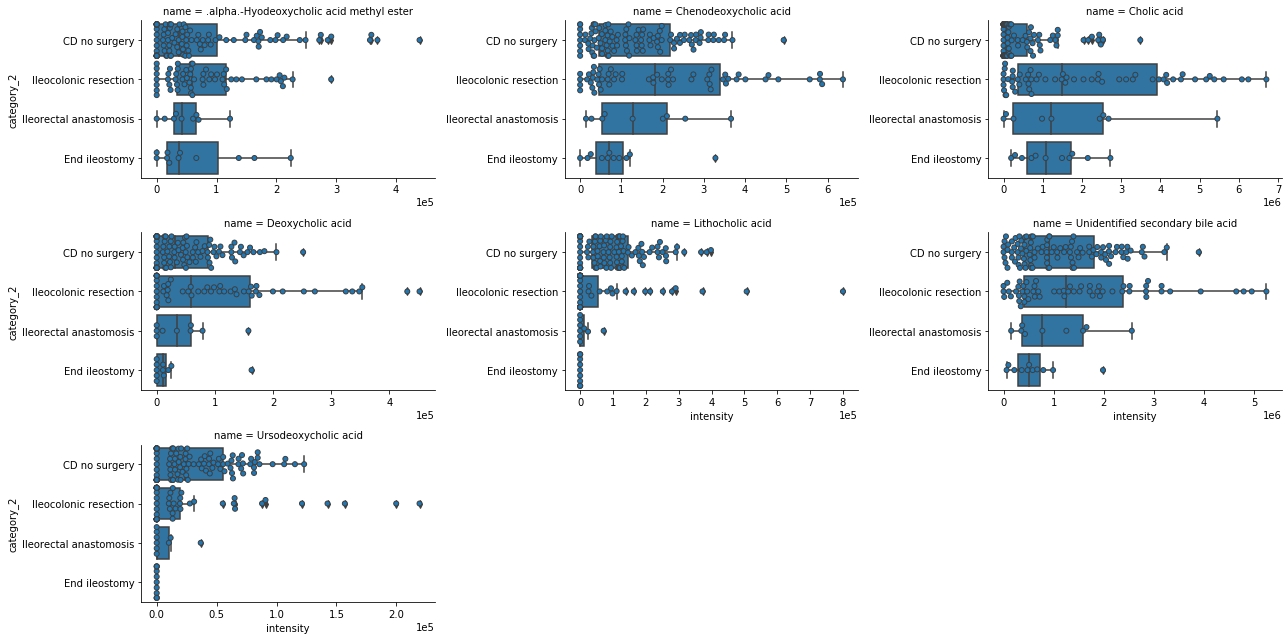

In [148]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Ileocolonic resection',
             'Ileorectal anastomosis', 'End ileostomy']
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, edgecolor="gray", linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['CD no surgery', 'Ileocolonic resection',
                   'Ileorectal anastomosis', 'End ileostomy'])

g = sns.FacetGrid(long_features.query('category_1 == "cd"'), col='name', col_wrap=3, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_2')

g.savefig('cd-bile-acids.pdf')

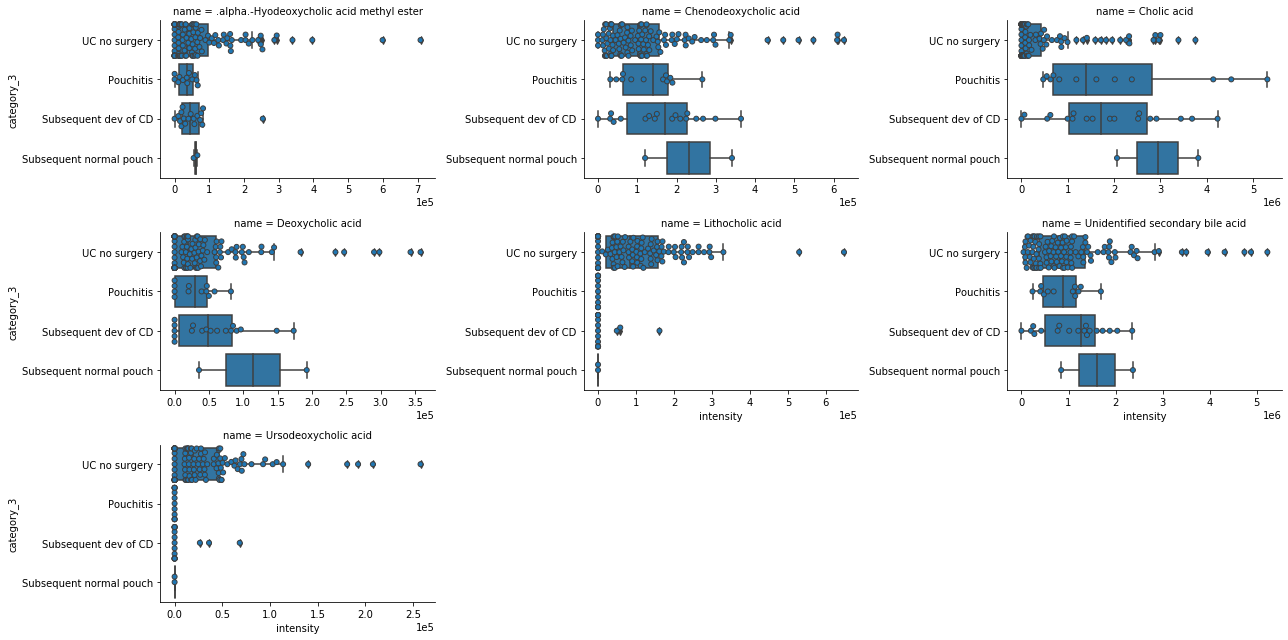

In [149]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Pouchitis',
             'Subsequent dev of CD', 'Subsequent normal pouch']
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, edgecolor="gray", linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['UC no surgery', 'Pouchitis',
                        'Subsequent dev of CD',
                        'Subsequent normal pouch'])

g = sns.FacetGrid(long_features.query('category_1 == "uc"'), col='name', col_wrap=3, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_3')
g.savefig('uc-bile-acids.pdf')

In [47]:
long_features.endoscopic_activity.value_counts()

not collected    262
active           254
inactive         146
Name: endoscopic_activity, dtype: int64

# Primary and secondary bile acids (surgery vs no surgery)

In [38]:
long_features.has_surgery.value_counts()

False    442
True     220
Name: has_surgery, dtype: int64

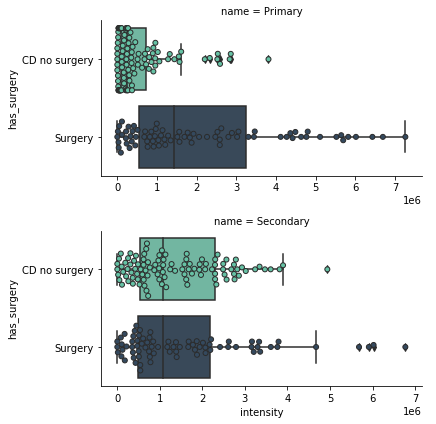

In [53]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['False', 'True']
    palette = {
        'False': '#66c2a5',
        'True': '#34495e',
    }
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, palette=palette, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, edgecolor="gray", dodge=True, linewidth=1,
                  palette=palette, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['CD no surgery', 'Surgery'])

g = sns.FacetGrid(long_features.query('category_1 == "cd"'), col='name', col_wrap=1, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'has_surgery').add_legend()

g.savefig('cd-bile-acids-type.surgery-vs-no-surgery.pdf')

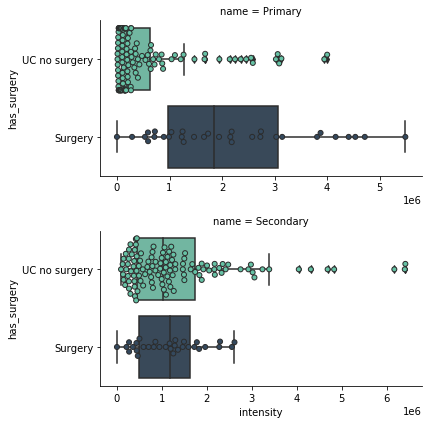

In [50]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['False', 'True']
    palette = {
        'False': '#66c2a5',
        'True': '#34495e',
    }
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, palette=palette, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, edgecolor="gray", dodge=True, linewidth=1,
                  palette=palette, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels([' no surgery', 'Surgery'])

g = sns.FacetGrid(long_features.query('category_1 == "uc"'), col='name', col_wrap=1, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'has_surgery').add_legend()

g.savefig('uc-bile-acids-type.surgery-vs-no-surgery.pdf')

# Primary and secondary bile acids

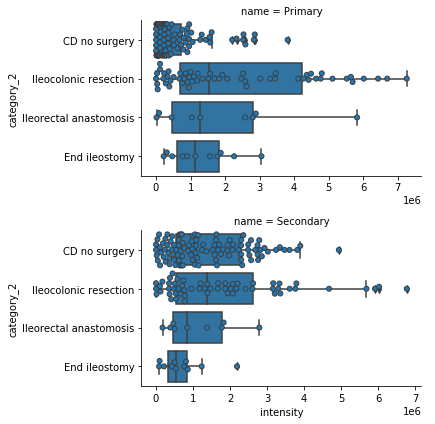

In [35]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Ileocolonic resection',
             'Ileorectal anastomosis', 'End ileostomy']
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, edgecolor="gray", dodge=True, linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['CD no surgery', 'Ileocolonic resection',
                        'Ileorectal anastomosis', 'End ileostomy'])

g = sns.FacetGrid(long_features.query('category_1 == "cd"'), col='name', col_wrap=1, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_2').add_legend()

# g.savefig('cd-bile-acids-type.pdf')

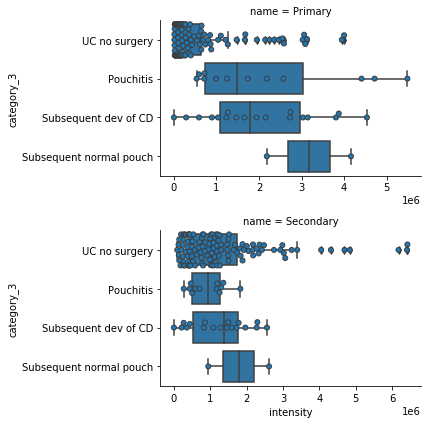

In [57]:
def swarmbox(x, y, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Pouchitis',
             'Subsequent dev of CD', 'Subsequent normal pouch']
    
    sns.boxplot(x=x, y=y, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, ax=ax, order=order, dodge=True, edgecolor="gray", linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['UC no surgery', 'Pouchitis',
                        'Subsequent dev of CD',
                        'Subsequent normal pouch'])

g = sns.FacetGrid(long_features.query('category_1 == "uc"'), col='name', col_wrap=1, aspect=2, legend_out=True,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_3').add_legend()
g.savefig('uc-bile-acids-type.pdf')

# Primary and secondary bile acids (with endoscopic activity)

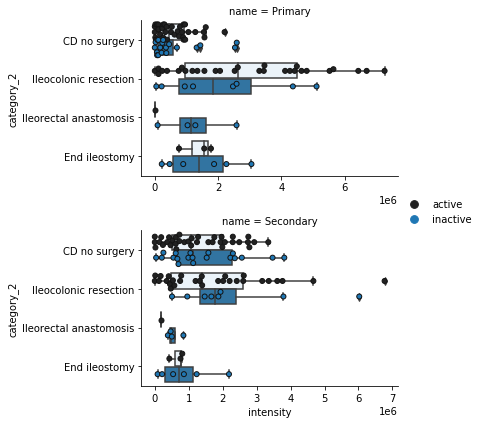

In [52]:
def swarmbox(x, y, hue, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Ileocolonic resection',
             'Ileorectal anastomosis', 'End ileostomy']
    
    sns.boxplot(x=x, y=y, hue=hue, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, hue=hue, ax=ax, order=order, edgecolor="gray", dodge=True, linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['CD no surgery', 'Ileocolonic resection',
                   'Ileorectal anastomosis', 'End ileostomy'])

g = sns.FacetGrid(long_features.query('category_1 == "cd" and endoscopic_activity != "not collected"'), col='name', col_wrap=1, aspect=2,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_2', 'endoscopic_activity').add_legend()

g.savefig('cd-bile-acids-type-with-endoscopic-activity.pdf')

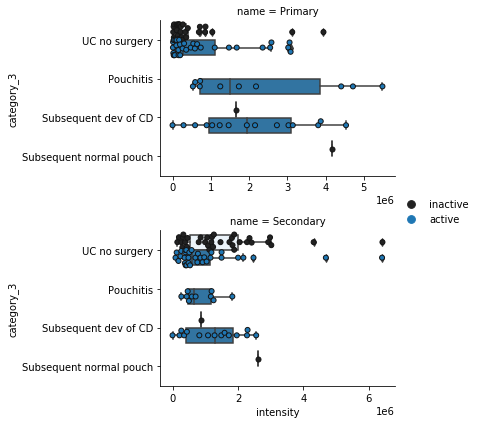

In [51]:
def swarmbox(x, y, hue, **kwargs):
    ax = plt.gca()
    order = ['Control', 'Pouchitis',
             'Subsequent dev of CD', 'Subsequent normal pouch']
    
    sns.boxplot(x=x, y=y, hue=hue, ax=ax, order=order, **kwargs)
    sns.swarmplot(x=x, y=y, hue=hue, ax=ax, order=order, dodge=True, edgecolor="gray", linewidth=1, **kwargs)
    
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 1))
    ax.set_yticklabels(['UC no surgery', 'Pouchitis',
                        'Subsequent dev of CD',
                        'Subsequent normal pouch'])

g = sns.FacetGrid(long_features.query('category_1 == "uc" and endoscopic_activity != "not collected"'), col='name', col_wrap=1, aspect=2, legend_out=True,
                  sharey=False, sharex=False)
g = g.map(swarmbox, 'intensity', 'category_3', 'endoscopic_activity').add_legend()
g.savefig('uc-bile-acids-type-with-endoscopic-activity.pdf')